## **OJECTIVE : Training classification model to find the model which would optimally classify legitimate and malicious domains.**

Dataset consist of 450k samples of legitimate and malicious domain urls and here I tend to explore the dataset and then train a classifier model which would optimally predict phishing and legitimate urls.

**NOTE** : As the dataset is imbalanced i will use SMOTE to oversample dataset.

In [ ]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier



# **Exploratory Data Analysis**

We have 21 features out of which 18 features were extracted from dataset in the previous notebook, the 'results' feature is the ground truth while the remaining 2 features ('url' , 'label') are only there for reference and can will be removed during training of the model.

In [ ]:
# loading out dataset from previous notebook
from google.colab import drive
drive.mount('/content/drive')
urldata = pd.read_csv("/content/Url_Processed.csv")

# droping "Unnamed: 0" as its unncessary feature
urldata.drop("Unnamed: 0",axis=1,inplace=True)

urldata.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,url,label,result,url_length,hostname_length,path_length,fd_length,count-,count@,count?,...,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip,short_url
0,https://www.google.com,benign,0,22,14,0,0,0,0,0,...,2,0,1,1,1,0,17,0,1,1
1,https://www.youtube.com,benign,0,23,15,0,0,0,0,0,...,2,0,1,1,1,0,18,0,1,1
2,https://www.facebook.com,benign,0,24,16,0,0,0,0,0,...,2,0,1,1,1,0,19,0,1,1
3,https://www.baidu.com,benign,0,21,13,0,0,0,0,0,...,2,0,1,1,1,0,16,0,1,1
4,https://www.wikipedia.org,benign,0,25,17,0,0,0,0,0,...,2,0,1,1,1,0,20,0,1,1
5,https://www.reddit.com,benign,0,22,14,0,0,0,0,0,...,2,0,1,1,1,0,17,0,1,-1
6,https://www.yahoo.com,benign,0,21,13,0,0,0,0,0,...,2,0,1,1,1,0,16,0,1,1
7,https://www.google.co.in,benign,0,24,16,0,0,0,0,0,...,3,0,1,1,1,0,18,0,1,1
8,https://www.qq.com,benign,0,18,10,0,0,0,0,0,...,2,0,1,1,1,0,13,0,1,1
9,https://www.amazon.com,benign,0,22,14,0,0,0,0,0,...,2,0,1,1,1,0,17,0,1,1


In [ ]:
urldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457790 entries, 0 to 457789
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   url              457790 non-null  object
 1   label            457790 non-null  object
 2   result           457790 non-null  int64 
 3   url_length       457790 non-null  int64 
 4   hostname_length  457790 non-null  int64 
 5   path_length      457790 non-null  int64 
 6   fd_length        457790 non-null  int64 
 7   count-           457790 non-null  int64 
 8   count@           457790 non-null  int64 
 9   count?           457790 non-null  int64 
 10  count%           457790 non-null  int64 
 11  count.           457790 non-null  int64 
 12  count=           457790 non-null  int64 
 13  count-http       457790 non-null  int64 
 14  count-https      457790 non-null  int64 
 15  count-www        457790 non-null  int64 
 16  count-digits     457790 non-null  int64 
 17  count-lett

benign       345738
malicious    104438
Name: label, dtype: int64


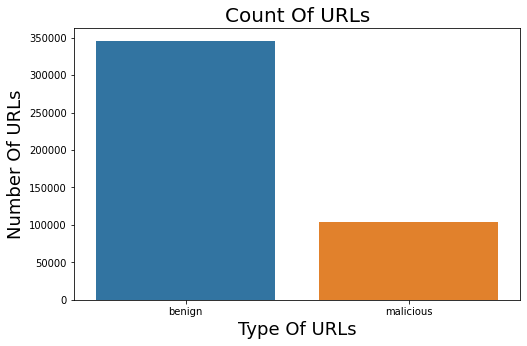

In [ ]:
# Lets find how many malicious and non-malicious samples we have
i = urldata["label"].value_counts()
print(i)

plt.figure(figsize=(8,5))
sns.countplot(x='label',data=urldata)
plt.title("Count Of URLs",fontsize=20)
plt.xlabel("Type Of URLs",fontsize=18)
plt.ylabel("Number Of URLs",fontsize=18)
plt.show()

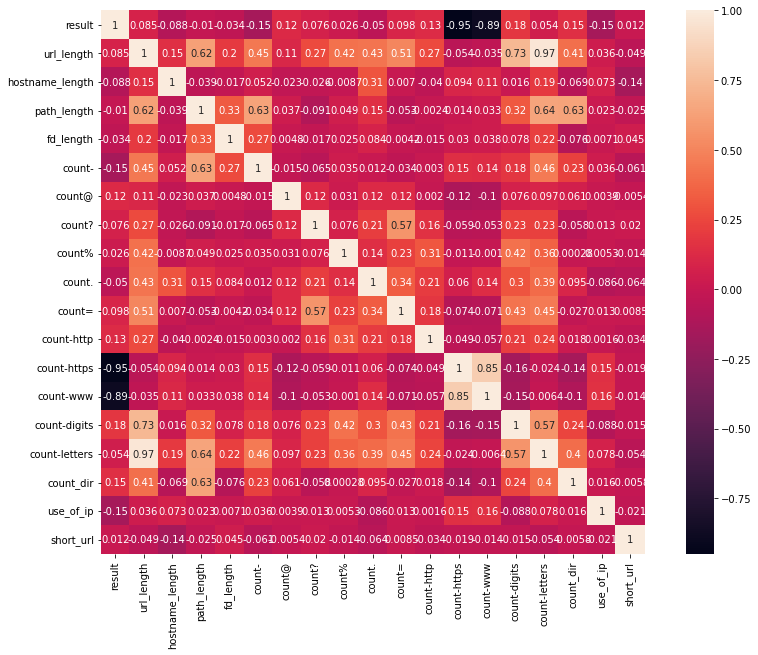

In [ ]:
#Correlation Heatmap
corrmat = urldata.corr()
f, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corrmat, square=True, annot = True, annot_kws={'size':10})

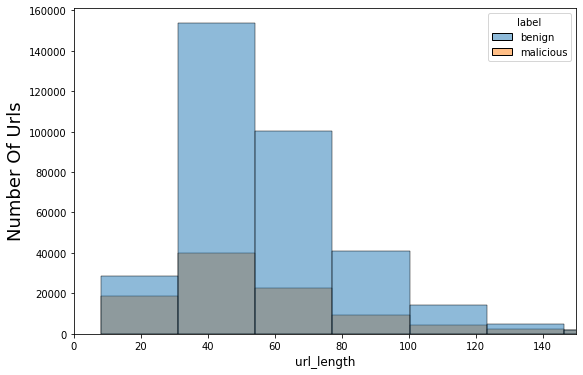

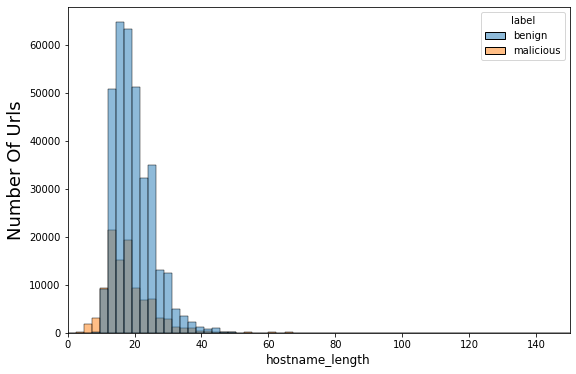

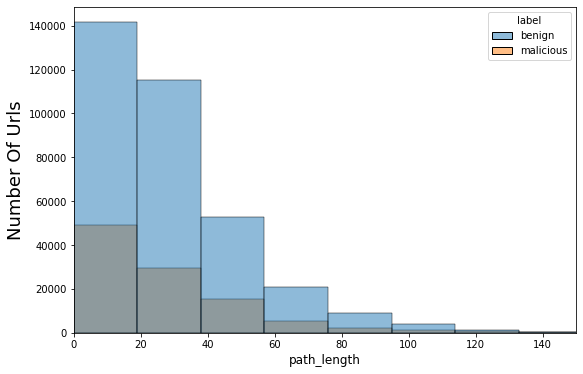

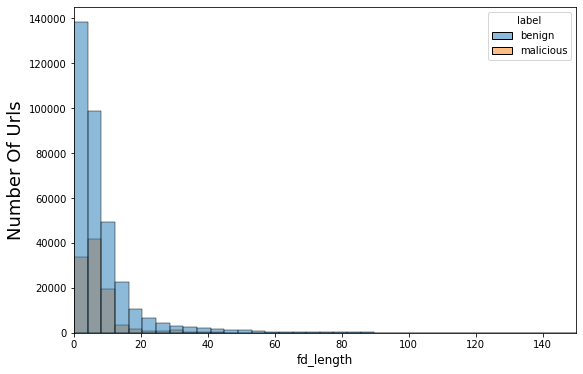

In [ ]:
# setting plot sizes
from matplotlib import rcParams
rcParams['figure.figsize'] = 9,6

# plotting distrubutions
features = list(urldata.columns) # list of feature names
features.remove("url")
features.remove("result")

hist_features = ["url_length","hostname_length","path_length","fd_length"]

for i in hist_features:
   sns.histplot(data=urldata,x=i,bins=100, hue='label')
   plt.xlabel(i,fontsize=12)
   plt.ylabel("Number Of Urls",fontsize=18)
   plt.xlim(0,150)
   plt.show()

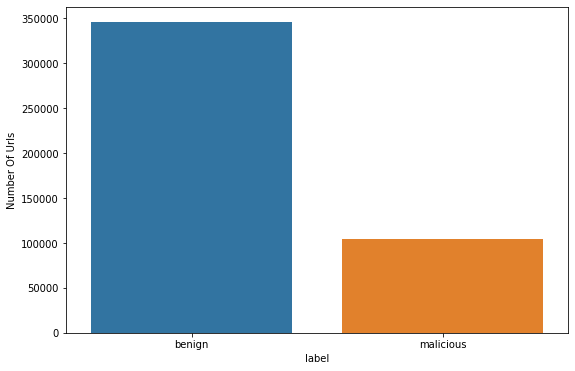

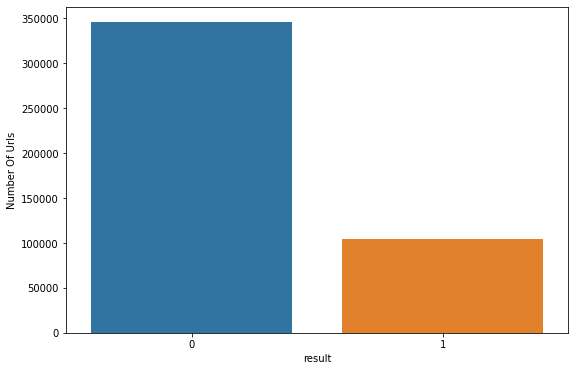

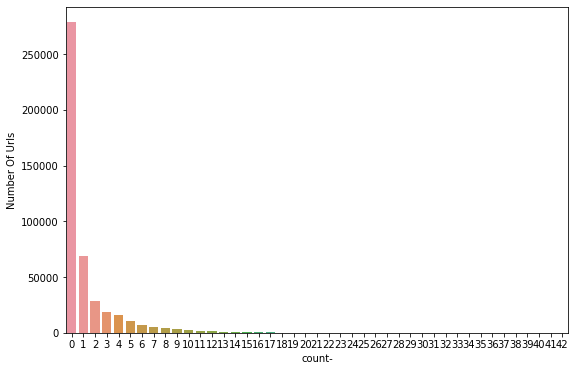

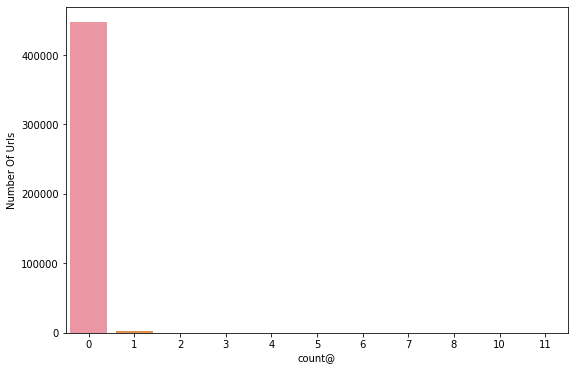

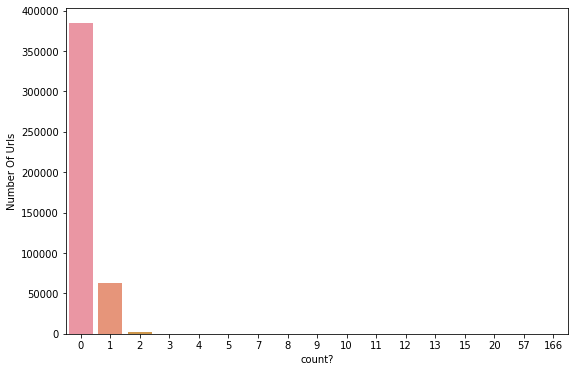

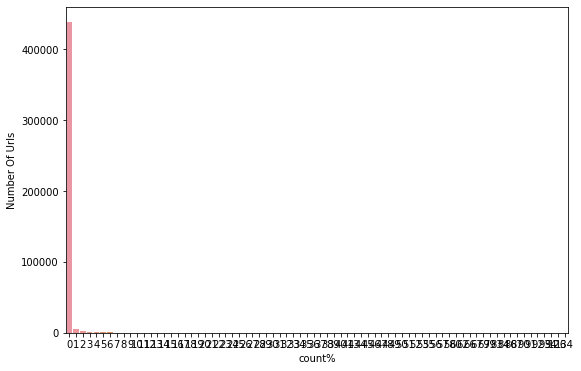

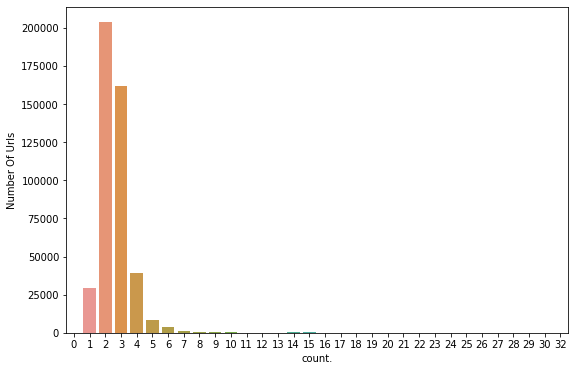

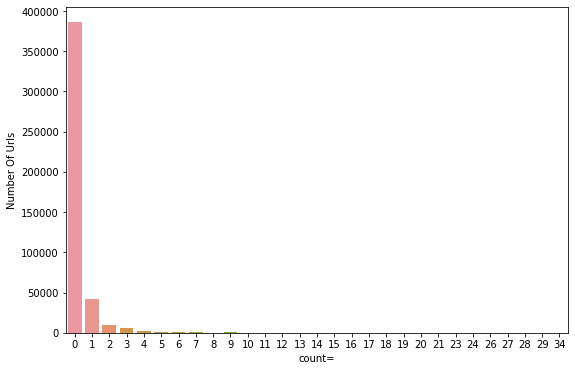

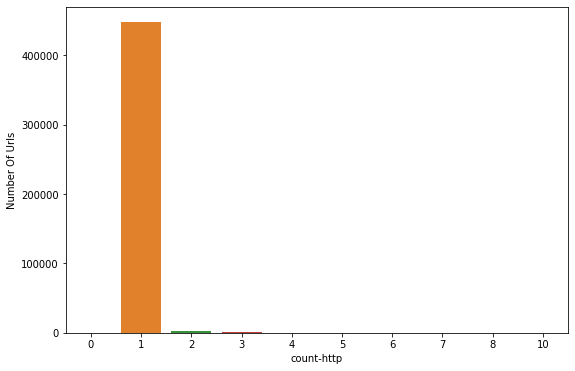

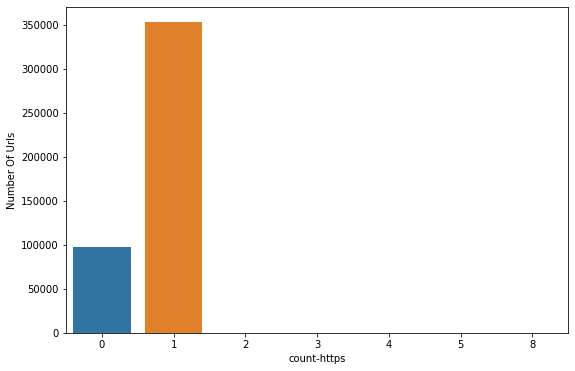

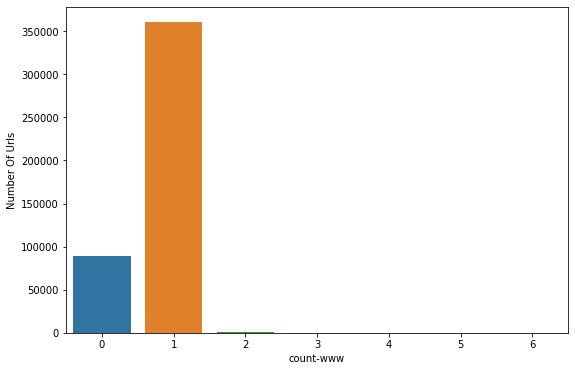

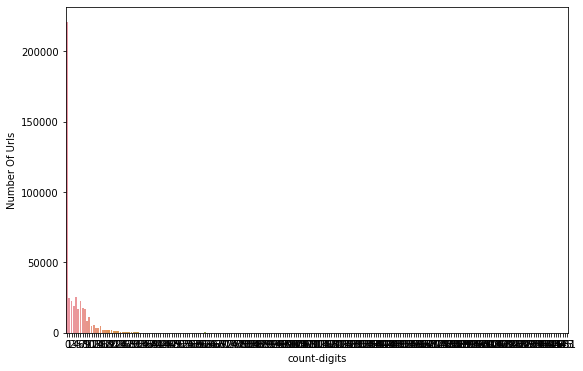

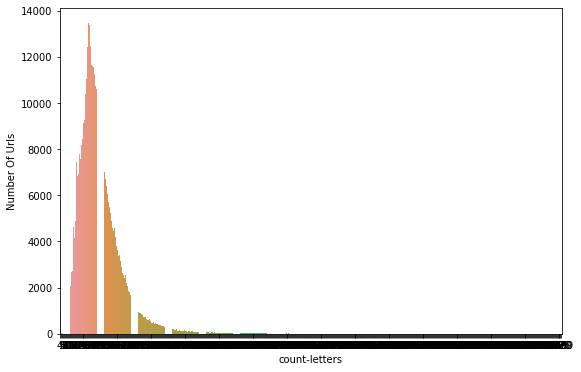

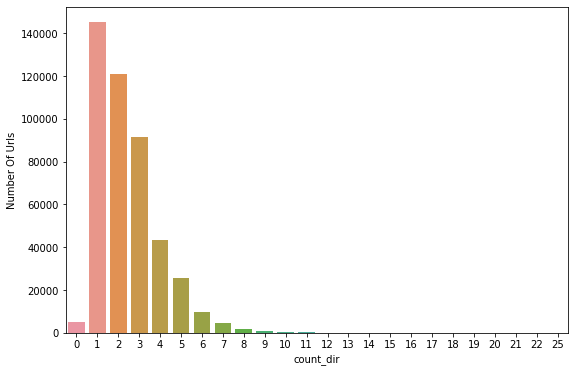

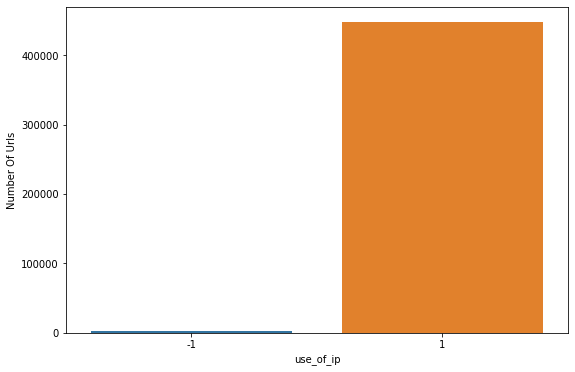

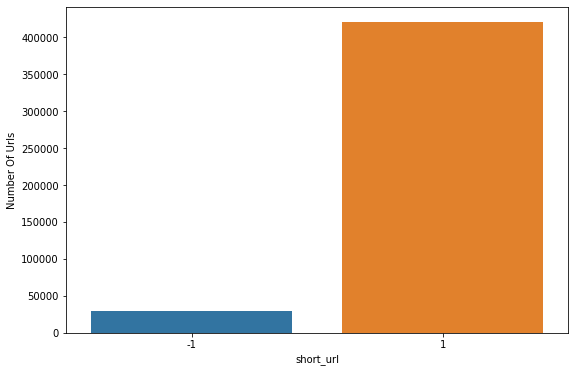

In [ ]:
# plotting distrubutions

features = list(urldata.columns) # list of feature names
features.remove("url")

rcParams['figure.figsize'] = 9,6

for i in features:
   
   if i in hist_features:
     continue
   
   sns.countplot(x=i,data=urldata)
   plt.xlabel(i,fontsize=10)
   plt.ylabel("Number Of Urls",fontsize=10)
   plt.show()
  

# **Model Training**

Before training our models we'll split the data into train and test dataset. We'll train multiple models and choose the one which gives us the best validation-accuracy. This problem falls under "Binary classification" and some of the models we'll train are :
- AdaBoost
- Linear Discriminant Analysis
- Decision Tree
- Random Forest
- Multilayer Perceptron (deep learning)

### **Data Splitting**

We'll follow a 80:20 ratio for data splitting,where we use 80% of data for training and 20% for testing.

In [ ]:
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,count-,count@,count?,...,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip,short_url
0,https://www.google.com,benign,0,22,14,0,0,0,0,0,...,2,0,1,1,1,0,17,0,1,1
1,https://www.youtube.com,benign,0,23,15,0,0,0,0,0,...,2,0,1,1,1,0,18,0,1,1
2,https://www.facebook.com,benign,0,24,16,0,0,0,0,0,...,2,0,1,1,1,0,19,0,1,1
3,https://www.baidu.com,benign,0,21,13,0,0,0,0,0,...,2,0,1,1,1,0,16,0,1,1
4,https://www.wikipedia.org,benign,0,25,17,0,0,0,0,0,...,2,0,1,1,1,0,20,0,1,1


In [ ]:
# remove uneccessary columns
urldata.drop(["url","label"],axis=1,inplace=True)

urldata.head()

,result,url_length,hostname_length,path_length,fd_length,count-,count@,count?,count%,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip,short_url
0,0,22,14,0,0,0,0,0,0,2,0,1,1,1,0,17,0,1,1
1,0,23,15,0,0,0,0,0,0,2,0,1,1,1,0,18,0,1,1
2,0,24,16,0,0,0,0,0,0,2,0,1,1,1,0,19,0,1,1
3,0,21,13,0,0,0,0,0,0,2,0,1,1,1,0,16,0,1,1
4,0,25,17,0,0,0,0,0,0,2,0,1,1,1,0,20,0,1,1


In [ ]:
# NOTE : We'll use only lexical features for this notebook i,e not taking 'url_length' and 'short_url'

#Independent Variables
x = urldata[['hostname_length',
       'path_length', 'fd_length', 'count-', 'count@', 'count?',
       'count%', 'count.', 'count=', 'count-http','count-https', 'count-www', 'count-digits',
       'count-letters', 'count_dir', 'use_of_ip', 'url_length', 'short_url']]

#Dependent Variable
y = urldata['result']

In [ ]:
# printing x
x.head()

,hostname_length,path_length,fd_length,count-,count@,count?,count%,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip,url_length,short_url
0,14,0,0,0,0,0,0,2,0,1,1,1,0,17,0,1,22,1
1,15,0,0,0,0,0,0,2,0,1,1,1,0,18,0,1,23,1
2,16,0,0,0,0,0,0,2,0,1,1,1,0,19,0,1,24,1
3,13,0,0,0,0,0,0,2,0,1,1,1,0,16,0,1,21,1
4,17,0,0,0,0,0,0,2,0,1,1,1,0,20,0,1,25,1


In [ ]:
# printing y
y.head()

0    0
1    0
2    0
3    0
4    0
Name: result, dtype: int64

#### **Oversampling Imbalanced Dataset**

During EDA we found that our dataset is Imbalanced,so we'll now use SMOTE method to oversample the dataset.

In [ ]:
#Oversampling using SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
#X, y = oversample.fit_resample(X, y)

x_sample, y_sample = SMOTE().fit_resample(x, y.values.ravel())

x_sample = pd.DataFrame(x_sample)
y_sample = pd.DataFrame(y_sample)

In [ ]:
# checking the sizes of the sample data
print("Size of x-sample :", x_sample.shape)
print("Size of y-sample :", y_sample.shape)

Size of x-sample : (691476, 18)
Size of y-sample : (691476, 1)


In [ ]:
# DATA SPLITTING 

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_sample, y_sample, test_size = 0.2)
#To check the total number of train data and test data after the split
print(x_sample.shape, x_train.shape, x_test.shape)

(691476, 18) (553180, 18) (138296, 18)


In [ ]:
#With imbalance dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
print(x.shape, x_train.shape, x_test.shape)

(450176, 18) (360140, 18) (90036, 18)


## **1. AdaBoost**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada_model = AdaBoostClassifier()
# start training the model
ada_model.fit(x_train,y_train)

AdaBoostClassifier()

#### **Model Performance Evaluation**

In [ ]:

y_pred_train = ada_model.predict(x_train)
ada_pred = ada_model.predict(x_test)

# finding accuracy on train dataset
train_acc = accuracy_score(y_train,y_pred_train)
test_acc = accuracy_score(y_test,ada_pred)

print("Accuracy of AdaBoost on Training dataset : ",round(train_acc,3))
print("Accuracy of AdaBoost on Testing dataset : ",round(test_acc,3))

Accuracy of AdaBoost on Training dataset :  0.997
Accuracy of AdaBoost on Testing dataset :  0.997


In [ ]:
# calculating other classification metrics
print('Confusion Matrix')
print(confusion_matrix(ada_pred,y_test))
print(classification_report(ada_pred,y_test,target_names=["legitimate","malicious"]))

Confusion Matrix
[[69089   159]
 [  130 20658]]
              precision    recall  f1-score   support

  legitimate       1.00      1.00      1.00     69248
   malicious       0.99      0.99      0.99     20788

    accuracy                           1.00     90036
   macro avg       1.00      1.00      1.00     90036
weighted avg       1.00      1.00      1.00     90036



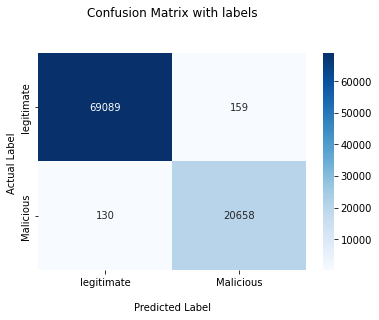

In [ ]:
ax = sns.heatmap(confusion_matrix(ada_pred, y_test), fmt='g', annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['legitimate', 'Malicious'])
ax.yaxis.set_ticklabels(['legitimate', 'Malicious'])

## Display the visualization of the Confusion Matrix.
plt.show()

## **2. LinearDiscriminantAnalysis (LDA)**

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis()
# start training the model
lda_model.fit(x_train,y_train)


LinearDiscriminantAnalysis()

In [ ]:
y_pred_train = lda_model.predict(x_train)
lda_pred = lda_model.predict(x_test)

# finding accuracy on train dataset
train_acc = accuracy_score(y_train,y_pred_train)
test_acc = accuracy_score(y_test,lda_pred)
print("Accuracy of LDA on Training dataset : ",round(train_acc,3))
print("Accuracy of LDA on Testing dataset : ",round(test_acc,3))

Accuracy of LDA on Training dataset :  0.984
Accuracy of LDA on Testing dataset :  0.984


In [ ]:
# calculating other classification metrics
print('Confusion Matrix')
print(confusion_matrix(lda_pred,y_test))
print(classification_report(lda_pred,y_test,target_names=["legitimate","malicious"]))

Confusion Matrix
[[69219  1443]
 [    0 19374]]
              precision    recall  f1-score   support

  legitimate       1.00      0.98      0.99     70662
   malicious       0.93      1.00      0.96     19374

    accuracy                           0.98     90036
   macro avg       0.97      0.99      0.98     90036
weighted avg       0.99      0.98      0.98     90036



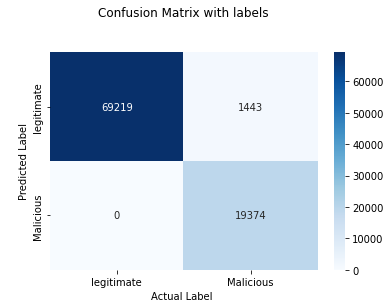

In [ ]:
ax = sns.heatmap(confusion_matrix(lda_pred,y_test), fmt='g', annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_ylabel('\nPredicted Label')
ax.set_xlabel('Actual Label ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['legitimate', 'Malicious'])
ax.yaxis.set_ticklabels(['legitimate', 'Malicious'])

## Display the visualization of the Confusion Matrix.
plt.show()

## **3. Decision Tree (DT)**

A decision tree is a flowchart-like structure in which each internal node represents a "test" on an attribute (e.g. whether a coin flip comes up heads or tails), each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes).

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()

# start training the model
dt_model.fit(x_train,y_train)

DecisionTreeClassifier()

In [ ]:
# finding y_pred for train and test dataset
y_pred_train = dt_model.predict(x_train)
dt_pred = dt_model.predict(x_test)

# finding accuracy on train dataset
train_acc = accuracy_score(y_train,y_pred_train)
test_acc = accuracy_score(y_test,dt_pred)

print("Accuracy of DT on Training dataset : ",round(train_acc,3))
print("Accuracy of DT on Testing dataset : ",round(test_acc,3))

Accuracy of DT on Training dataset :  0.999
Accuracy of DT on Testing dataset :  0.996


In [ ]:
# calculating other classification metrics
print('Confusion Matrix')
print(confusion_matrix(dt_pred,y_test))
print(classification_report(dt_pred,y_test,target_names=["legitimate","malicious"]))

Confusion Matrix
[[69049   187]
 [  170 20630]]
              precision    recall  f1-score   support

  legitimate       1.00      1.00      1.00     69236
   malicious       0.99      0.99      0.99     20800

    accuracy                           1.00     90036
   macro avg       0.99      0.99      0.99     90036
weighted avg       1.00      1.00      1.00     90036



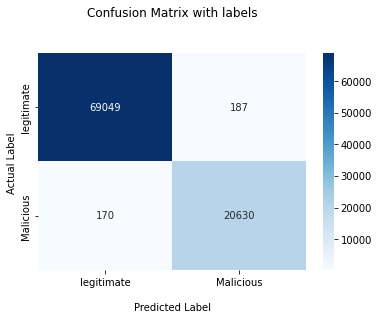

In [ ]:
ax = sns.heatmap(confusion_matrix(dt_pred,y_test), fmt='g', annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['legitimate', 'Malicious'])
ax.yaxis.set_ticklabels(['legitimate', 'Malicious'])

## Display the visualization of the Confusion Matrix.
plt.show()

## **5. Random Forest (RF)**
Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees.

In [ ]:
rf_model = RandomForestClassifier(n_estimators=10)

# start training the model
rf_model.fit(x_train,y_train)

RandomForestClassifier(n_estimators=10)

In [ ]:
# finding y_pred for train and test dataset
y_pred_train = rf_model.predict(x_train)
rf_pred = rf_model.predict(x_test)

# finding accuracy on train dataset
train_acc = accuracy_score(y_train,y_pred_train)
test_acc = accuracy_score(y_test,rf_pred)

print("Accuracy of RF on Training dataset : ",round(train_acc,3))
print("Accuracy of RF on Testing dataset : ",round(test_acc,3))

Accuracy of RF on Training dataset :  0.999
Accuracy of RF on Testing dataset :  0.997


In [ ]:
# calculating other classification metrics
print('Confusion Matrix')
print(confusion_matrix(rf_pred,y_test))
print(classification_report(rf_pred,y_test,target_names=["legitimate","malicious"]))

Confusion Matrix
[[69149   166]
 [   70 20651]]
              precision    recall  f1-score   support

  legitimate       1.00      1.00      1.00     69315
   malicious       0.99      1.00      0.99     20721

    accuracy                           1.00     90036
   macro avg       1.00      1.00      1.00     90036
weighted avg       1.00      1.00      1.00     90036



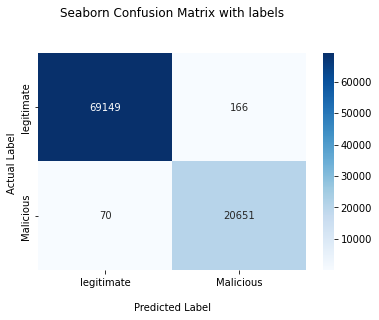

In [ ]:
ax = sns.heatmap(confusion_matrix(rf_pred,y_test), fmt='g', annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['legitimate', 'Malicious'])
ax.yaxis.set_ticklabels(['legitimate', 'Malicious'])

## Display the visualization of the Confusion Matrix.
plt.show()

##**6. ExtraTree Classifier**

In [ ]:
xrf_model = ExtraTreesClassifier()

# start training the model
xrf_model.fit(x_train,y_train)
'''xrf_accuracy = fit_evaluate_model(xrf_classifier, X_train, y_train, X_valid, y_valid)
print("Number of correct predictions made out of all predictions are:", xrf_accuracy)'''

'xrf_accuracy = fit_evaluate_model(xrf_classifier, X_train, y_train, X_valid, y_valid)\nprint("Number of correct predictions made out of all predictions are:", xrf_accuracy)'

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred_train = xrf_model.predict(x_train)
xrf_pred = xrf_model.predict(x_test)

# finding accuracy on train dataset
train_acc = accuracy_score(y_train,y_pred_train)
test_acc = accuracy_score(y_test,xrf_pred)

print("Accuracy of XRF on Training dataset : ",round(train_acc,3))
print("Accuracy of XRF on Testing dataset : ",round(test_acc,3))

Accuracy of XRF on Training dataset :  0.999
Accuracy of XRF on Testing dataset :  0.997


In [ ]:
# calculating other classification metrics
print('Confusion Matrix')
print(confusion_matrix(xrf_pred,y_test))
print(classification_report(xrf_pred,y_test,target_names=["legitimate","malicious"]))

Confusion Matrix
[[69143   163]
 [   76 20654]]
              precision    recall  f1-score   support

  legitimate       1.00      1.00      1.00     69306
   malicious       0.99      1.00      0.99     20730

    accuracy                           1.00     90036
   macro avg       1.00      1.00      1.00     90036
weighted avg       1.00      1.00      1.00     90036



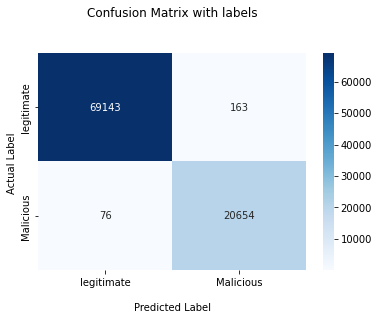

In [ ]:
ax = sns.heatmap(confusion_matrix(xrf_pred,y_test), fmt='g', annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['legitimate', 'Malicious'])
ax.yaxis.set_ticklabels(['legitimate', 'Malicious'])

## Display the visualization of the Confusion Matrix.
plt.show()

## **4. K-NearestNeighbour(KNN)**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
# start training the model
knn_model.fit(x_train,y_train)

KNeighborsClassifier()

In [ ]:
# finding y_pred for train and test dataset
y_pred_train = knn_model.predict(x_train)
knn_pred = knn_model.predict(x_test)

# finding accuracy on train dataset
train_acc = accuracy_score(y_train,y_pred_train)
test_acc = accuracy_score(y_test,knn_pred)

print("Accuracy of KNN on Training dataset : ",round(train_acc,3))
print("Accuracy of KNN on Testing dataset : ",round(test_acc,3))

Accuracy of KNN on Training dataset :  0.971
Accuracy of KNN on Testing dataset :  0.959


In [ ]:
# calculating other classification metrics
print('Confusion Matrix')
print(confusion_matrix(knn_pred,y_test))
print(classification_report(knn_pred,y_test,target_names=["legitimate","malicious"]))

Confusion Matrix
[[68462  2967]
 [  757 17850]]
              precision    recall  f1-score   support

  legitimate       0.99      0.96      0.97     71429
   malicious       0.86      0.96      0.91     18607

    accuracy                           0.96     90036
   macro avg       0.92      0.96      0.94     90036
weighted avg       0.96      0.96      0.96     90036



##Accuracy Score of our ML Classifiers

In [ ]:

#Overall Accuracy table
classifier = np.array(['AdaBoost', 'LinearDiscriminantAnalysis',  'KNearestNeighbour','DecisionTree', 'RandomForest', 'ExtraTree'])
scr = np.array([accuracy_score(y_test,ada_pred)*100, accuracy_score(y_test,lda_pred)*100, accuracy_score(y_test,knn_pred)*100, accuracy_score(y_test, dt_pred)*100, accuracy_score(y_test,rf_pred)*100, accuracy_score(y_test,xrf_pred)*100])
tbl = pd.DataFrame({"Classifier": classifier,"Accuracy_Score(%)": scr})
tbl.style.highlight_max(subset = "Accuracy_Score(%)",
                       color = 'lightgreen', axis = 0)


,Classifier,Accuracy_Score(%)
0,AdaBoost,99.679017
1,LinearDiscriminantAnalysis,98.397308
2,KNearestNeighbour,95.863877
3,DecisionTree,99.603492
4,RandomForest,99.737883
5,ExtraTree,99.734551


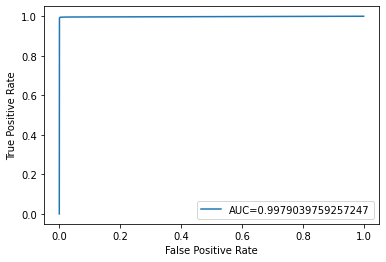

In [ ]:
#define metrics for best classifier
import sklearn.metrics as metrics
y_pred_proba = rf_model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

##feature importance of best classifier.

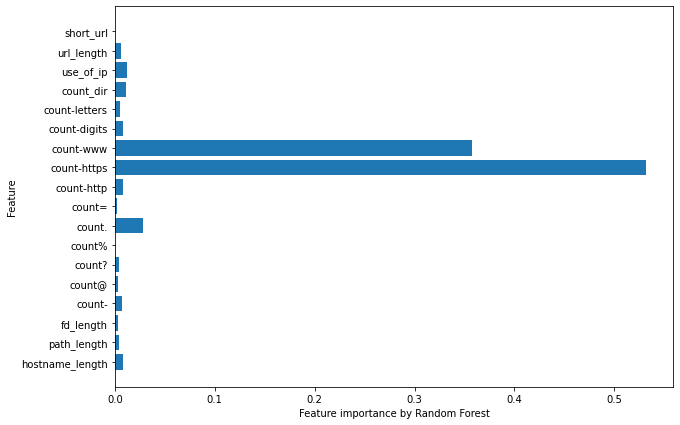

In [ ]:

feature_names = ['hostname_length',
       'path_length', 'fd_length', 'count-', 'count@', 'count?',
       'count%', 'count.', 'count=', 'count-http','count-https', 'count-www', 'count-digits',
       'count-letters', 'count_dir', 'use_of_ip','url_length', 'short_url']

#checking the feature improtance in the model
plt.figure(figsize=(10,7))
n_features = x_train.shape[1]
plt.barh(range(n_features), xrf_model.feature_importances_, align='center')
plt.yticks(np.arange(n_features),feature_names)
plt.xlabel("Feature importance by Random Forest")
plt.ylabel("Feature")
plt.show()

## **7. Multilayer Perceptron (Deep Learning)**
A multilayer perceptron (MLP) is a feedforward artificial neural network that generates a set of outputs from a set of inputs. An MLP is characterized by several layers of input nodes connected as a directed graph between the input and output layers. MLP uses backpropogation for training the network.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization ,Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# print input shape
x_train.shape

(366499, 18)

In [ ]:
# model building
model = Sequential()
model.add(Dense(32, activation = 'relu', input_shape = (18, )))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu')) 
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                608       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compiling model
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer= opt ,loss='binary_crossentropy',metrics=['acc'])

In [ ]:
# custom callback to stop the training when certain metric value is reached

# stop training when validation loss reach 0.1
class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')>0.1):
            print("\nReached 0.1 val_loss so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()

In [ ]:
# start training the model 
history = model.fit(x_train, y_train, epochs=3,batch_size=260, callbacks=[callback],validation_data=(x_test,y_test),verbose=1)

Epoch 1/3
1391/1410 [============================>.] - ETA: 0s - loss: 0.5288 - acc: 0.7774
Reached 0.1 val_loss so cancelling training!
1410/1410 [==============================] - 5s 3ms/step - loss: 0.5269 - acc: 0.7780 - val_loss: 0.3843 - val_acc: 0.8290


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


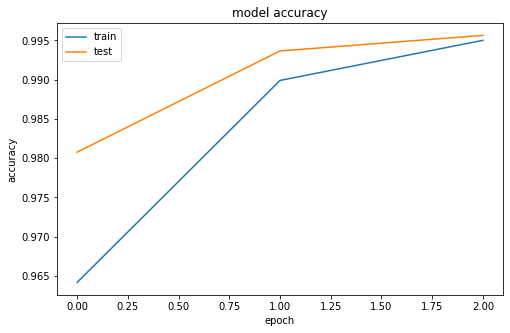

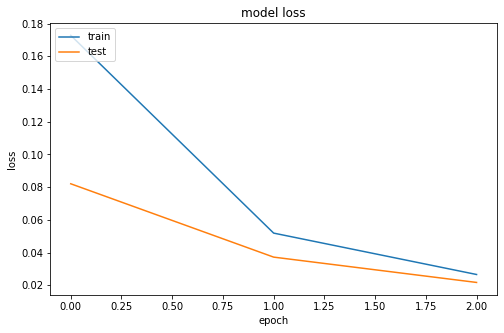

In [ ]:
# DISPLAYING MODEL TRAINING HISTORY

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:

# Evaluate the model on test dataset
loss, acc = model.evaluate(x_test,y_test,verbose=1)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

2864/2864 [==============================] - 4s 2ms/step - loss: 0.3843 - acc: 0.8290
Test loss: 0.38431552052497864
Test Accuracy: 0.8289549946784973


In [ ]:
# calculating other classification metrics
print('Confusion Matrix')
print(confusion_matrix(xrf_pred,y_test))
print(classification_report(xrf_pred,y_test,target_names=["legitimate","malicious"]))

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
for i in range (len(pred_test)):
    if (pred_test[i] < 0.5):
        pred_test[i] = 0
    else:
        pred_test[i] = 1
pred_test = pred_test.astype(int)

def view_result(array):
    array = np.array(array)
    for i in range(len(array)):
        if array[i] == 0:
            print("Non Mallicious")
        else:
            print("Mallicious")

print("PREDICTED : ")
view_result(pred_test[:11])
print("\n")
print("ACTUAL : ")
view_result(y_test[:11])

2864/2864 [==============================] - 4s 1ms/step
PREDICTED : 
Non Mallicious
Non Mallicious
Mallicious
Non Mallicious
Non Mallicious
Non Mallicious
Non Mallicious
Mallicious
Non Mallicious
Non Mallicious
Mallicious


ACTUAL : 
Non Mallicious
Non Mallicious
Mallicious
Non Mallicious
Non Mallicious
Mallicious
Non Mallicious
Mallicious
Mallicious
Non Mallicious
Mallicious
